# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

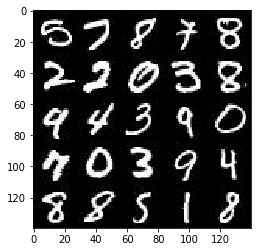

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

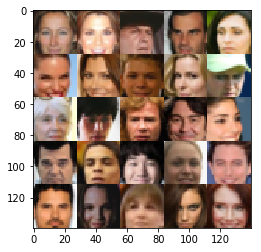

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Create placeholders for input data
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_input")
    z_input = tf.placeholder(tf.float32, [None, z_dim], name="z_input")
    
    # Create placeholders for hyperparameters
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return (real_input, z_input, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # Reuse variables
    with tf.variable_scope("discriminator", reuse=reuse):
        
        # Images have dimensions 28x28x<out_channel_dim>
        # * Run images through convolutional filters
        # * Use batch normalization in layers (except the first!) for better numerical properties
        # * Activation functions:
        # * - No activation in the initial "fully connected" layer
        # * - Leaky ReLU in conv layers
        # * - Sigmoid in output layer (to classify real/fake)
        
        # Hyperparams
        alpha = 0.2
        kernel_size = 3 # Same in all dims
        stride_size = 2 # Same in all dims
        kernel_stddev = 0.03

        ### Convolutions
        # 28x28x3 => 14x14x64
        conv1 = tf.layers.conv2d(images, 64, kernel_size, strides=stride_size, padding="same",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=kernel_stddev))
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        # 14x14x64 => 7x7x128
        conv2 = tf.layers.conv2d(conv1, 128, kernel_size, strides=stride_size, padding="same",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=kernel_stddev))
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        # 7x7x128 => 4x4x256
        conv3 = tf.layers.conv2d(conv2, 256, kernel_size, strides=stride_size, padding="same",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=kernel_stddev))
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)

        # Flatten: 4x4x256 => 4096
        flattened = tf.reshape(conv3, (-1, 4*4*256))

        # Classify if the image is real or fake 
        # 4096 => 1
        logits = tf.layers.dense(flattened, 1, activation=None,
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=kernel_stddev))
        out = tf.sigmoid(logits)
        
        return (out, logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    # Reuse variables
    with tf.variable_scope("generator", reuse=not is_train):
        
        # Images shall have dimensions 28x28x<out_channel_dim>
        # * Run images through transpose convolutional filters
        # * Use batch normalization in layers for better numerical properties
        # * Activation functions:
        # * - No activation in the initial "fully connected" layer
        # * - Leaky ReLU in transpose convolutional layers
        # * - tanh in output layer
 
        # Hyperparams
        alpha = 0.2
        kernel_stddev = 0.03
        
        # Convolution parameters
        kernel_size = 3 # Same in all dims
        stride_size = 2 # Same in all dims

        # Run z through a "fully connected" layer (really just a matrix multiplication)
        # Reshape fc output vector to a 4D tensor to be ready for convolutions
        # <z_dim> => 3072 => 3x3x512
        fc = tf.layers.dense(z, 3*3*512, activation=None)
        fc = tf.reshape(fc, (-1, 3, 3, 512))
        fc = tf.layers.batch_normalization(fc, training=is_train)
        fc = tf.maximum(alpha*fc, fc)
        
        # 3x3x512 => 7x7x256
        convT1 = tf.layers.conv2d_transpose(fc, 256, kernel_size, stride_size, "valid",
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=kernel_stddev))
        convT1 = tf.layers.batch_normalization(convT1, training=is_train)
        convT1 = tf.maximum(alpha*convT1, convT1)
        
        # 7x7x256 => 14x14x128
        convT2 = tf.layers.conv2d_transpose(convT1, 128, kernel_size, stride_size, "same",
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=kernel_stddev))
        convT2 = tf.layers.batch_normalization(convT2, training=is_train)
        convT2 = tf.maximum(alpha*convT2, convT2)

        # 14x14x128 => 28x28x<out_channel_dim>
        logits = tf.layers.conv2d_transpose(convT2, out_channel_dim, kernel_size, stride_size, "same",
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=kernel_stddev))
        out = tf.tanh(logits)

        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Apply label smoothing for real images
    # Gives better generalization
    label_smoothing = 0.9

    # Create generator
    g_out = generator(input_z, out_channel_dim, is_train=True)

    # Create discriminator
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)

    ### Calculate losses
    # Loss for REAL images (label = 1)
    # Use label smoothing 
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real) * label_smoothing))

    # Loss for FAKE images (label = 0)
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    # Generator loss
    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))


    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Separate trainable variables for the generator and discriminator
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

    
    # Create Adam optimizers for generator and discriminator separately
    # Typically adjust first momentum of Adam for stabilization
    g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    d_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return (d_optimizer, g_optimizer) 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    # Clarify some variable names
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]

    
    ### Build DCGAN
    # Create input placeholders
    real_input, z_input, lr = model_inputs(image_width, image_height, image_channels, z_dim)

    # Define losses
    d_loss, g_loss = model_loss(real_input, z_input, image_channels)

    # Define optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    
    ### Train DCGAN 
    n_total_batches = data_shape[0] // batch_size
   
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_counter = 0
            
            for batch_images in get_batches(batch_size):
                batch_counter += 1
                
                # Real images have values [-0.5, 0.5] after preprocessing
                # Generator images however have values [-1, 1] (tanh activation)
                # Thus, scale real image values to [-1, 1] as well
                batch_images = batch_images*2.0

                # Sample random noise to feed the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                # Take three optimization steps in G for every in D to stabilize training
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, 
                                               z_input: batch_z,
                                               lr: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={z_input: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: batch_z,
                                               lr: learning_rate})

                # Monitor losses during training
                if batch_counter % 10 == 0:
                    training_loss_d = sess.run(d_loss, feed_dict={real_input: batch_images, 
                                                                  z_input: batch_z})
                    
                    training_loss_g = sess.run(g_loss, feed_dict={z_input: batch_z})

                    print("Epoch {}/{} - Batch {}/{}: ".format(epoch_i+1, epoch_count, batch_counter, n_total_batches),
                          "Discriminator loss = {:.4f} ".format(training_loss_d),
                          "Generator loss = {:.4f}".format(training_loss_g))
                                        
                # Sample generator output every once in a while
                if batch_counter % 100 == 0:
                    show_generator_output(sess, 25, z_input, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 - Batch 10/500:  Discriminator loss = 2.8493  Generator loss = 0.1478
Epoch 1/2 - Batch 20/500:  Discriminator loss = 2.7029  Generator loss = 0.1658
Epoch 1/2 - Batch 30/500:  Discriminator loss = 1.6281  Generator loss = 0.8946
Epoch 1/2 - Batch 40/500:  Discriminator loss = 1.6138  Generator loss = 1.4561
Epoch 1/2 - Batch 50/500:  Discriminator loss = 1.8009  Generator loss = 0.8510
Epoch 1/2 - Batch 60/500:  Discriminator loss = 1.7487  Generator loss = 1.0659
Epoch 1/2 - Batch 70/500:  Discriminator loss = 1.6374  Generator loss = 0.5352
Epoch 1/2 - Batch 80/500:  Discriminator loss = 1.5860  Generator loss = 1.1594
Epoch 1/2 - Batch 90/500:  Discriminator loss = 1.5282  Generator loss = 0.6852
Epoch 1/2 - Batch 100/500:  Discriminator loss = 1.5597  Generator loss = 0.4954


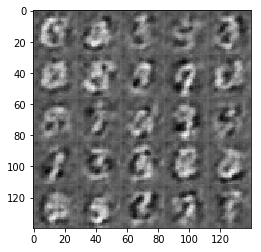

Epoch 1/2 - Batch 110/500:  Discriminator loss = 1.5230  Generator loss = 0.5366
Epoch 1/2 - Batch 120/500:  Discriminator loss = 1.6146  Generator loss = 0.4906
Epoch 1/2 - Batch 130/500:  Discriminator loss = 1.4334  Generator loss = 0.5938
Epoch 1/2 - Batch 140/500:  Discriminator loss = 1.6227  Generator loss = 0.5218
Epoch 1/2 - Batch 150/500:  Discriminator loss = 1.5757  Generator loss = 0.5076
Epoch 1/2 - Batch 160/500:  Discriminator loss = 1.4421  Generator loss = 1.2503
Epoch 1/2 - Batch 170/500:  Discriminator loss = 1.5060  Generator loss = 0.9575
Epoch 1/2 - Batch 180/500:  Discriminator loss = 1.4751  Generator loss = 0.7493
Epoch 1/2 - Batch 190/500:  Discriminator loss = 1.5031  Generator loss = 0.5378
Epoch 1/2 - Batch 200/500:  Discriminator loss = 1.4777  Generator loss = 0.8711


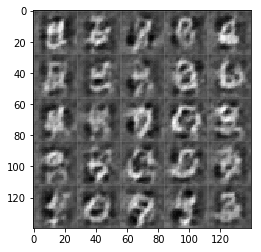

Epoch 1/2 - Batch 210/500:  Discriminator loss = 1.3788  Generator loss = 0.6545
Epoch 1/2 - Batch 220/500:  Discriminator loss = 1.4583  Generator loss = 0.5023
Epoch 1/2 - Batch 230/500:  Discriminator loss = 1.5231  Generator loss = 0.5314
Epoch 1/2 - Batch 240/500:  Discriminator loss = 1.4873  Generator loss = 0.4914
Epoch 1/2 - Batch 250/500:  Discriminator loss = 1.6110  Generator loss = 1.2713
Epoch 1/2 - Batch 260/500:  Discriminator loss = 1.4112  Generator loss = 0.6563
Epoch 1/2 - Batch 270/500:  Discriminator loss = 1.4208  Generator loss = 0.6734
Epoch 1/2 - Batch 280/500:  Discriminator loss = 1.5639  Generator loss = 0.4440
Epoch 1/2 - Batch 290/500:  Discriminator loss = 1.3482  Generator loss = 1.0004
Epoch 1/2 - Batch 300/500:  Discriminator loss = 1.4482  Generator loss = 0.7987


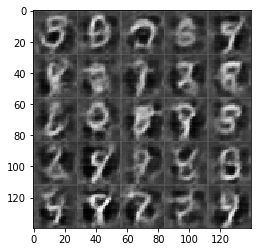

Epoch 1/2 - Batch 310/500:  Discriminator loss = 1.4980  Generator loss = 0.8089
Epoch 1/2 - Batch 320/500:  Discriminator loss = 1.3956  Generator loss = 0.7156
Epoch 1/2 - Batch 330/500:  Discriminator loss = 1.4745  Generator loss = 0.9210
Epoch 1/2 - Batch 340/500:  Discriminator loss = 1.3922  Generator loss = 0.7000
Epoch 1/2 - Batch 350/500:  Discriminator loss = 1.4775  Generator loss = 0.8101
Epoch 1/2 - Batch 360/500:  Discriminator loss = 1.4312  Generator loss = 0.8856
Epoch 1/2 - Batch 370/500:  Discriminator loss = 1.4469  Generator loss = 0.8225
Epoch 1/2 - Batch 380/500:  Discriminator loss = 1.4031  Generator loss = 0.6986
Epoch 1/2 - Batch 390/500:  Discriminator loss = 1.3641  Generator loss = 0.7740
Epoch 1/2 - Batch 400/500:  Discriminator loss = 1.4824  Generator loss = 0.6025


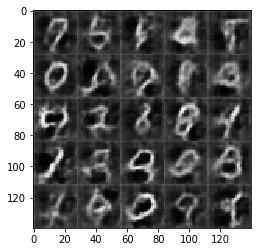

Epoch 1/2 - Batch 410/500:  Discriminator loss = 1.3587  Generator loss = 1.0424
Epoch 1/2 - Batch 420/500:  Discriminator loss = 1.5027  Generator loss = 1.2414
Epoch 1/2 - Batch 430/500:  Discriminator loss = 1.5232  Generator loss = 1.1708
Epoch 1/2 - Batch 440/500:  Discriminator loss = 1.4405  Generator loss = 1.2481
Epoch 1/2 - Batch 450/500:  Discriminator loss = 1.3920  Generator loss = 0.9993
Epoch 1/2 - Batch 460/500:  Discriminator loss = 1.9798  Generator loss = 1.8874
Epoch 1/2 - Batch 470/500:  Discriminator loss = 1.3753  Generator loss = 0.8336
Epoch 1/2 - Batch 480/500:  Discriminator loss = 1.3459  Generator loss = 0.8372
Epoch 1/2 - Batch 490/500:  Discriminator loss = 1.3660  Generator loss = 0.7408
Epoch 1/2 - Batch 500/500:  Discriminator loss = 1.3878  Generator loss = 0.9133


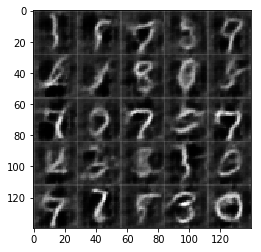

Epoch 2/2 - Batch 10/500:  Discriminator loss = 1.4046  Generator loss = 1.0886
Epoch 2/2 - Batch 20/500:  Discriminator loss = 1.4034  Generator loss = 0.5990
Epoch 2/2 - Batch 30/500:  Discriminator loss = 1.6148  Generator loss = 0.4100
Epoch 2/2 - Batch 40/500:  Discriminator loss = 1.4126  Generator loss = 0.8447
Epoch 2/2 - Batch 50/500:  Discriminator loss = 1.4821  Generator loss = 0.5026
Epoch 2/2 - Batch 60/500:  Discriminator loss = 1.4153  Generator loss = 1.0666
Epoch 2/2 - Batch 70/500:  Discriminator loss = 1.3126  Generator loss = 0.8464
Epoch 2/2 - Batch 80/500:  Discriminator loss = 1.4251  Generator loss = 0.5834
Epoch 2/2 - Batch 90/500:  Discriminator loss = 1.4202  Generator loss = 0.9488
Epoch 2/2 - Batch 100/500:  Discriminator loss = 1.3576  Generator loss = 0.8836


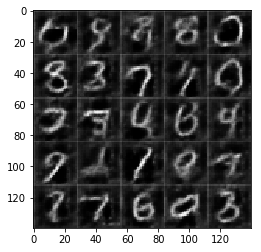

Epoch 2/2 - Batch 110/500:  Discriminator loss = 1.3666  Generator loss = 0.6929
Epoch 2/2 - Batch 120/500:  Discriminator loss = 1.5243  Generator loss = 0.4279
Epoch 2/2 - Batch 130/500:  Discriminator loss = 1.3951  Generator loss = 0.7605
Epoch 2/2 - Batch 140/500:  Discriminator loss = 1.4012  Generator loss = 0.6652
Epoch 2/2 - Batch 150/500:  Discriminator loss = 1.6345  Generator loss = 0.3619
Epoch 2/2 - Batch 160/500:  Discriminator loss = 1.3523  Generator loss = 0.9012
Epoch 2/2 - Batch 170/500:  Discriminator loss = 1.5653  Generator loss = 0.4129
Epoch 2/2 - Batch 180/500:  Discriminator loss = 1.2864  Generator loss = 0.9019
Epoch 2/2 - Batch 190/500:  Discriminator loss = 1.4791  Generator loss = 0.4710
Epoch 2/2 - Batch 200/500:  Discriminator loss = 1.4567  Generator loss = 0.5607


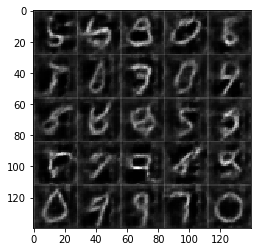

Epoch 2/2 - Batch 210/500:  Discriminator loss = 1.3466  Generator loss = 0.6650
Epoch 2/2 - Batch 220/500:  Discriminator loss = 1.4067  Generator loss = 0.5752
Epoch 2/2 - Batch 230/500:  Discriminator loss = 1.4430  Generator loss = 0.6117
Epoch 2/2 - Batch 240/500:  Discriminator loss = 1.4062  Generator loss = 0.6146
Epoch 2/2 - Batch 250/500:  Discriminator loss = 1.4892  Generator loss = 0.4647
Epoch 2/2 - Batch 260/500:  Discriminator loss = 2.1503  Generator loss = 0.1883
Epoch 2/2 - Batch 270/500:  Discriminator loss = 1.3262  Generator loss = 0.7498
Epoch 2/2 - Batch 280/500:  Discriminator loss = 1.6188  Generator loss = 0.3577
Epoch 2/2 - Batch 290/500:  Discriminator loss = 1.4136  Generator loss = 0.8582
Epoch 2/2 - Batch 300/500:  Discriminator loss = 1.4059  Generator loss = 0.5409


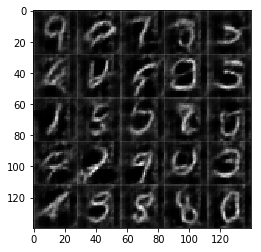

Epoch 2/2 - Batch 310/500:  Discriminator loss = 1.9603  Generator loss = 0.2332
Epoch 2/2 - Batch 320/500:  Discriminator loss = 1.4146  Generator loss = 0.6039
Epoch 2/2 - Batch 330/500:  Discriminator loss = 1.3872  Generator loss = 0.8276
Epoch 2/2 - Batch 340/500:  Discriminator loss = 1.3123  Generator loss = 0.6645
Epoch 2/2 - Batch 350/500:  Discriminator loss = 1.3639  Generator loss = 0.7534
Epoch 2/2 - Batch 360/500:  Discriminator loss = 1.3404  Generator loss = 0.7438
Epoch 2/2 - Batch 370/500:  Discriminator loss = 1.5083  Generator loss = 1.4928
Epoch 2/2 - Batch 380/500:  Discriminator loss = 1.5358  Generator loss = 0.4563
Epoch 2/2 - Batch 390/500:  Discriminator loss = 1.3110  Generator loss = 0.6666
Epoch 2/2 - Batch 400/500:  Discriminator loss = 1.4197  Generator loss = 0.7934


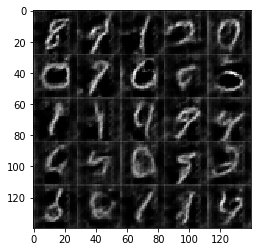

Epoch 2/2 - Batch 410/500:  Discriminator loss = 1.2662  Generator loss = 0.8542
Epoch 2/2 - Batch 420/500:  Discriminator loss = 1.4833  Generator loss = 0.9604
Epoch 2/2 - Batch 430/500:  Discriminator loss = 1.3392  Generator loss = 0.8453
Epoch 2/2 - Batch 440/500:  Discriminator loss = 1.6821  Generator loss = 0.3439
Epoch 2/2 - Batch 450/500:  Discriminator loss = 1.2763  Generator loss = 1.0845
Epoch 2/2 - Batch 460/500:  Discriminator loss = 1.3663  Generator loss = 0.6264
Epoch 2/2 - Batch 470/500:  Discriminator loss = 1.5695  Generator loss = 0.3958
Epoch 2/2 - Batch 480/500:  Discriminator loss = 1.4106  Generator loss = 0.5022
Epoch 2/2 - Batch 490/500:  Discriminator loss = 1.4290  Generator loss = 0.7409
Epoch 2/2 - Batch 500/500:  Discriminator loss = 1.6685  Generator loss = 0.3426


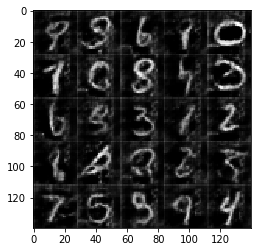

In [15]:
batch_size = 120
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2


mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - Batch 10/1582:  Discriminator loss = 5.7444  Generator loss = 0.0259
Epoch 1/1 - Batch 20/1582:  Discriminator loss = 3.9244  Generator loss = 0.1249
Epoch 1/1 - Batch 30/1582:  Discriminator loss = 2.5196  Generator loss = 0.2650
Epoch 1/1 - Batch 40/1582:  Discriminator loss = 2.9176  Generator loss = 0.2708
Epoch 1/1 - Batch 50/1582:  Discriminator loss = 2.1053  Generator loss = 0.4620
Epoch 1/1 - Batch 60/1582:  Discriminator loss = 2.4627  Generator loss = 0.3581
Epoch 1/1 - Batch 70/1582:  Discriminator loss = 1.8220  Generator loss = 0.6144
Epoch 1/1 - Batch 80/1582:  Discriminator loss = 1.9372  Generator loss = 0.5763
Epoch 1/1 - Batch 90/1582:  Discriminator loss = 1.7652  Generator loss = 0.6359
Epoch 1/1 - Batch 100/1582:  Discriminator loss = 1.5963  Generator loss = 0.6688


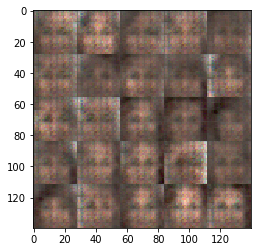

Epoch 1/1 - Batch 110/1582:  Discriminator loss = 1.7946  Generator loss = 0.5628
Epoch 1/1 - Batch 120/1582:  Discriminator loss = 1.5331  Generator loss = 0.6742
Epoch 1/1 - Batch 130/1582:  Discriminator loss = 1.5738  Generator loss = 0.6606
Epoch 1/1 - Batch 140/1582:  Discriminator loss = 1.6297  Generator loss = 0.5548
Epoch 1/1 - Batch 150/1582:  Discriminator loss = 1.6057  Generator loss = 0.6340
Epoch 1/1 - Batch 160/1582:  Discriminator loss = 1.6780  Generator loss = 0.7381
Epoch 1/1 - Batch 170/1582:  Discriminator loss = 1.6737  Generator loss = 0.6191
Epoch 1/1 - Batch 180/1582:  Discriminator loss = 1.7116  Generator loss = 0.5338
Epoch 1/1 - Batch 190/1582:  Discriminator loss = 1.5680  Generator loss = 0.6809
Epoch 1/1 - Batch 200/1582:  Discriminator loss = 1.6379  Generator loss = 0.6247


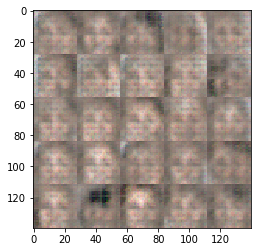

Epoch 1/1 - Batch 210/1582:  Discriminator loss = 1.5413  Generator loss = 0.6830
Epoch 1/1 - Batch 220/1582:  Discriminator loss = 1.4576  Generator loss = 0.7398
Epoch 1/1 - Batch 230/1582:  Discriminator loss = 1.6533  Generator loss = 0.6484
Epoch 1/1 - Batch 240/1582:  Discriminator loss = 1.7540  Generator loss = 0.6207
Epoch 1/1 - Batch 250/1582:  Discriminator loss = 1.6383  Generator loss = 0.6537
Epoch 1/1 - Batch 260/1582:  Discriminator loss = 1.5124  Generator loss = 0.7303
Epoch 1/1 - Batch 270/1582:  Discriminator loss = 1.6216  Generator loss = 0.6135
Epoch 1/1 - Batch 280/1582:  Discriminator loss = 1.5158  Generator loss = 0.6542
Epoch 1/1 - Batch 290/1582:  Discriminator loss = 1.5856  Generator loss = 0.6035
Epoch 1/1 - Batch 300/1582:  Discriminator loss = 1.5372  Generator loss = 0.7032


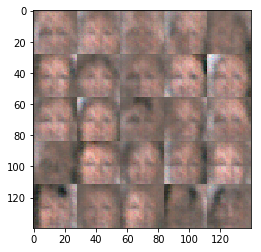

Epoch 1/1 - Batch 310/1582:  Discriminator loss = 1.5782  Generator loss = 0.7294
Epoch 1/1 - Batch 320/1582:  Discriminator loss = 1.6111  Generator loss = 0.6217
Epoch 1/1 - Batch 330/1582:  Discriminator loss = 1.6415  Generator loss = 0.5631
Epoch 1/1 - Batch 340/1582:  Discriminator loss = 1.6880  Generator loss = 0.5151
Epoch 1/1 - Batch 350/1582:  Discriminator loss = 1.5651  Generator loss = 0.6453
Epoch 1/1 - Batch 360/1582:  Discriminator loss = 1.4848  Generator loss = 0.6420
Epoch 1/1 - Batch 370/1582:  Discriminator loss = 1.6012  Generator loss = 0.5950
Epoch 1/1 - Batch 380/1582:  Discriminator loss = 1.5233  Generator loss = 0.7399
Epoch 1/1 - Batch 390/1582:  Discriminator loss = 1.6156  Generator loss = 0.6950
Epoch 1/1 - Batch 400/1582:  Discriminator loss = 1.4935  Generator loss = 0.7846


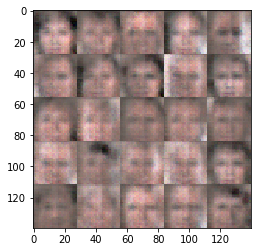

Epoch 1/1 - Batch 410/1582:  Discriminator loss = 1.5256  Generator loss = 0.7202
Epoch 1/1 - Batch 420/1582:  Discriminator loss = 1.5046  Generator loss = 0.6774
Epoch 1/1 - Batch 430/1582:  Discriminator loss = 1.5562  Generator loss = 0.8132
Epoch 1/1 - Batch 440/1582:  Discriminator loss = 1.5509  Generator loss = 0.7563
Epoch 1/1 - Batch 450/1582:  Discriminator loss = 1.6054  Generator loss = 0.6695
Epoch 1/1 - Batch 460/1582:  Discriminator loss = 1.5316  Generator loss = 0.5922
Epoch 1/1 - Batch 470/1582:  Discriminator loss = 1.4860  Generator loss = 0.7361
Epoch 1/1 - Batch 480/1582:  Discriminator loss = 1.5168  Generator loss = 0.7333
Epoch 1/1 - Batch 490/1582:  Discriminator loss = 1.5392  Generator loss = 0.6607
Epoch 1/1 - Batch 500/1582:  Discriminator loss = 1.5441  Generator loss = 0.7280


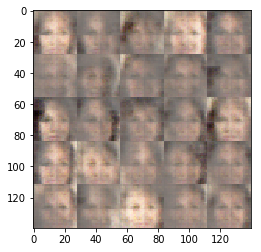

Epoch 1/1 - Batch 510/1582:  Discriminator loss = 1.5352  Generator loss = 0.6676
Epoch 1/1 - Batch 520/1582:  Discriminator loss = 1.5651  Generator loss = 0.5969
Epoch 1/1 - Batch 530/1582:  Discriminator loss = 1.5523  Generator loss = 0.7179
Epoch 1/1 - Batch 540/1582:  Discriminator loss = 1.6462  Generator loss = 0.6903
Epoch 1/1 - Batch 550/1582:  Discriminator loss = 1.4068  Generator loss = 0.7271
Epoch 1/1 - Batch 560/1582:  Discriminator loss = 1.4539  Generator loss = 0.8796
Epoch 1/1 - Batch 570/1582:  Discriminator loss = 1.5135  Generator loss = 0.5351
Epoch 1/1 - Batch 580/1582:  Discriminator loss = 1.5568  Generator loss = 0.6458
Epoch 1/1 - Batch 590/1582:  Discriminator loss = 1.6944  Generator loss = 0.7350
Epoch 1/1 - Batch 600/1582:  Discriminator loss = 1.5480  Generator loss = 0.6418


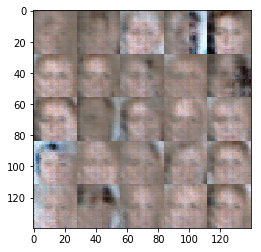

Epoch 1/1 - Batch 610/1582:  Discriminator loss = 1.6090  Generator loss = 0.9608
Epoch 1/1 - Batch 620/1582:  Discriminator loss = 1.4533  Generator loss = 0.6596
Epoch 1/1 - Batch 630/1582:  Discriminator loss = 1.6392  Generator loss = 0.5909
Epoch 1/1 - Batch 640/1582:  Discriminator loss = 1.5878  Generator loss = 0.6405
Epoch 1/1 - Batch 650/1582:  Discriminator loss = 1.4375  Generator loss = 0.7346
Epoch 1/1 - Batch 660/1582:  Discriminator loss = 1.4602  Generator loss = 0.7823
Epoch 1/1 - Batch 670/1582:  Discriminator loss = 1.4680  Generator loss = 0.8122
Epoch 1/1 - Batch 680/1582:  Discriminator loss = 1.5528  Generator loss = 0.6834
Epoch 1/1 - Batch 690/1582:  Discriminator loss = 1.5091  Generator loss = 0.8318
Epoch 1/1 - Batch 700/1582:  Discriminator loss = 1.4811  Generator loss = 0.8093


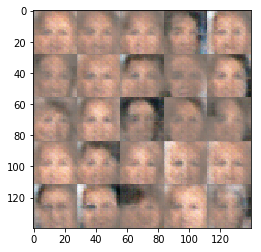

Epoch 1/1 - Batch 710/1582:  Discriminator loss = 1.4968  Generator loss = 0.7681
Epoch 1/1 - Batch 720/1582:  Discriminator loss = 1.4846  Generator loss = 0.6762
Epoch 1/1 - Batch 730/1582:  Discriminator loss = 1.4911  Generator loss = 0.5965
Epoch 1/1 - Batch 740/1582:  Discriminator loss = 1.4302  Generator loss = 0.6605
Epoch 1/1 - Batch 750/1582:  Discriminator loss = 1.4813  Generator loss = 0.7411
Epoch 1/1 - Batch 760/1582:  Discriminator loss = 1.5591  Generator loss = 0.5858
Epoch 1/1 - Batch 770/1582:  Discriminator loss = 1.3940  Generator loss = 0.6933
Epoch 1/1 - Batch 780/1582:  Discriminator loss = 1.4747  Generator loss = 0.7022
Epoch 1/1 - Batch 790/1582:  Discriminator loss = 1.5475  Generator loss = 0.7027
Epoch 1/1 - Batch 800/1582:  Discriminator loss = 1.4316  Generator loss = 0.8070


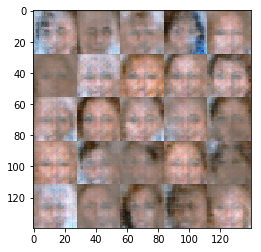

Epoch 1/1 - Batch 810/1582:  Discriminator loss = 1.4350  Generator loss = 0.8456
Epoch 1/1 - Batch 820/1582:  Discriminator loss = 1.4996  Generator loss = 0.7827
Epoch 1/1 - Batch 830/1582:  Discriminator loss = 1.5840  Generator loss = 0.6402
Epoch 1/1 - Batch 840/1582:  Discriminator loss = 1.4792  Generator loss = 0.7334
Epoch 1/1 - Batch 850/1582:  Discriminator loss = 1.5274  Generator loss = 0.6084
Epoch 1/1 - Batch 860/1582:  Discriminator loss = 1.4606  Generator loss = 0.7629
Epoch 1/1 - Batch 870/1582:  Discriminator loss = 1.6435  Generator loss = 0.7986
Epoch 1/1 - Batch 880/1582:  Discriminator loss = 1.5401  Generator loss = 0.7179
Epoch 1/1 - Batch 890/1582:  Discriminator loss = 1.5220  Generator loss = 0.6678
Epoch 1/1 - Batch 900/1582:  Discriminator loss = 1.4661  Generator loss = 0.8186


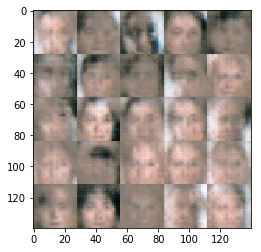

Epoch 1/1 - Batch 910/1582:  Discriminator loss = 1.3930  Generator loss = 0.7769
Epoch 1/1 - Batch 920/1582:  Discriminator loss = 1.4371  Generator loss = 0.7992
Epoch 1/1 - Batch 930/1582:  Discriminator loss = 1.4473  Generator loss = 0.7516
Epoch 1/1 - Batch 940/1582:  Discriminator loss = 1.5241  Generator loss = 0.7587
Epoch 1/1 - Batch 950/1582:  Discriminator loss = 1.4845  Generator loss = 0.7674
Epoch 1/1 - Batch 960/1582:  Discriminator loss = 1.5616  Generator loss = 0.7049
Epoch 1/1 - Batch 970/1582:  Discriminator loss = 1.4975  Generator loss = 0.7460
Epoch 1/1 - Batch 980/1582:  Discriminator loss = 1.6183  Generator loss = 0.6927
Epoch 1/1 - Batch 990/1582:  Discriminator loss = 1.5376  Generator loss = 0.6505
Epoch 1/1 - Batch 1000/1582:  Discriminator loss = 1.5005  Generator loss = 0.6946


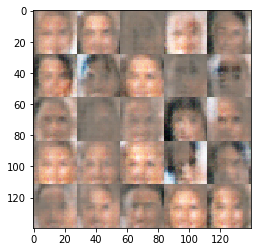

Epoch 1/1 - Batch 1010/1582:  Discriminator loss = 1.5630  Generator loss = 0.6735
Epoch 1/1 - Batch 1020/1582:  Discriminator loss = 1.5245  Generator loss = 0.7252
Epoch 1/1 - Batch 1030/1582:  Discriminator loss = 1.4302  Generator loss = 0.6772
Epoch 1/1 - Batch 1040/1582:  Discriminator loss = 1.4758  Generator loss = 0.7725
Epoch 1/1 - Batch 1050/1582:  Discriminator loss = 1.4829  Generator loss = 0.6909
Epoch 1/1 - Batch 1060/1582:  Discriminator loss = 1.4600  Generator loss = 0.6923
Epoch 1/1 - Batch 1070/1582:  Discriminator loss = 1.5437  Generator loss = 0.6848
Epoch 1/1 - Batch 1080/1582:  Discriminator loss = 1.4963  Generator loss = 0.7022
Epoch 1/1 - Batch 1090/1582:  Discriminator loss = 1.5104  Generator loss = 0.8074
Epoch 1/1 - Batch 1100/1582:  Discriminator loss = 1.5163  Generator loss = 0.6895


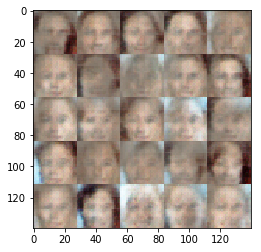

Epoch 1/1 - Batch 1110/1582:  Discriminator loss = 1.5357  Generator loss = 0.5814
Epoch 1/1 - Batch 1120/1582:  Discriminator loss = 1.4867  Generator loss = 0.7745
Epoch 1/1 - Batch 1130/1582:  Discriminator loss = 1.4823  Generator loss = 0.8300
Epoch 1/1 - Batch 1140/1582:  Discriminator loss = 1.5141  Generator loss = 0.6944
Epoch 1/1 - Batch 1150/1582:  Discriminator loss = 1.4969  Generator loss = 0.8029
Epoch 1/1 - Batch 1160/1582:  Discriminator loss = 1.4198  Generator loss = 0.8201
Epoch 1/1 - Batch 1170/1582:  Discriminator loss = 1.4298  Generator loss = 0.6865
Epoch 1/1 - Batch 1180/1582:  Discriminator loss = 1.4857  Generator loss = 0.8713
Epoch 1/1 - Batch 1190/1582:  Discriminator loss = 1.4642  Generator loss = 0.8375
Epoch 1/1 - Batch 1200/1582:  Discriminator loss = 1.4440  Generator loss = 0.7228


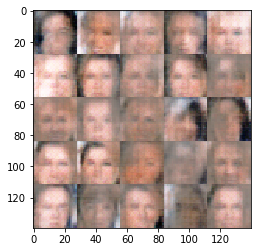

Epoch 1/1 - Batch 1210/1582:  Discriminator loss = 1.4043  Generator loss = 0.7687
Epoch 1/1 - Batch 1220/1582:  Discriminator loss = 1.4554  Generator loss = 0.6623
Epoch 1/1 - Batch 1230/1582:  Discriminator loss = 1.4511  Generator loss = 0.8525
Epoch 1/1 - Batch 1240/1582:  Discriminator loss = 1.4897  Generator loss = 0.7258
Epoch 1/1 - Batch 1250/1582:  Discriminator loss = 1.4830  Generator loss = 0.7633
Epoch 1/1 - Batch 1260/1582:  Discriminator loss = 1.5479  Generator loss = 0.6846
Epoch 1/1 - Batch 1270/1582:  Discriminator loss = 1.4914  Generator loss = 0.6739
Epoch 1/1 - Batch 1280/1582:  Discriminator loss = 1.4279  Generator loss = 0.7158
Epoch 1/1 - Batch 1290/1582:  Discriminator loss = 1.4319  Generator loss = 0.8580
Epoch 1/1 - Batch 1300/1582:  Discriminator loss = 1.5055  Generator loss = 0.7417


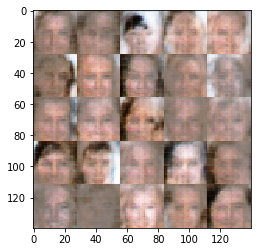

Epoch 1/1 - Batch 1310/1582:  Discriminator loss = 1.4556  Generator loss = 0.8250
Epoch 1/1 - Batch 1320/1582:  Discriminator loss = 1.5075  Generator loss = 0.7564
Epoch 1/1 - Batch 1330/1582:  Discriminator loss = 1.5128  Generator loss = 0.7050
Epoch 1/1 - Batch 1340/1582:  Discriminator loss = 1.4462  Generator loss = 0.7637
Epoch 1/1 - Batch 1350/1582:  Discriminator loss = 1.4303  Generator loss = 0.6787
Epoch 1/1 - Batch 1360/1582:  Discriminator loss = 1.4587  Generator loss = 0.7582
Epoch 1/1 - Batch 1370/1582:  Discriminator loss = 1.4890  Generator loss = 0.7240
Epoch 1/1 - Batch 1380/1582:  Discriminator loss = 1.5868  Generator loss = 0.6881
Epoch 1/1 - Batch 1390/1582:  Discriminator loss = 1.4930  Generator loss = 0.6944
Epoch 1/1 - Batch 1400/1582:  Discriminator loss = 1.5145  Generator loss = 0.6123


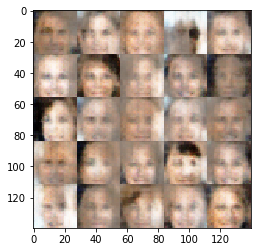

Epoch 1/1 - Batch 1410/1582:  Discriminator loss = 1.5072  Generator loss = 0.6898
Epoch 1/1 - Batch 1420/1582:  Discriminator loss = 1.4231  Generator loss = 0.7514
Epoch 1/1 - Batch 1430/1582:  Discriminator loss = 1.4685  Generator loss = 0.6952
Epoch 1/1 - Batch 1440/1582:  Discriminator loss = 1.4294  Generator loss = 0.8660
Epoch 1/1 - Batch 1450/1582:  Discriminator loss = 1.4393  Generator loss = 0.6495
Epoch 1/1 - Batch 1460/1582:  Discriminator loss = 1.4740  Generator loss = 0.6834
Epoch 1/1 - Batch 1470/1582:  Discriminator loss = 1.4725  Generator loss = 0.6117
Epoch 1/1 - Batch 1480/1582:  Discriminator loss = 1.4680  Generator loss = 0.7896
Epoch 1/1 - Batch 1490/1582:  Discriminator loss = 1.4323  Generator loss = 0.7432
Epoch 1/1 - Batch 1500/1582:  Discriminator loss = 1.4204  Generator loss = 0.8859


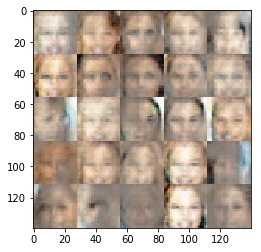

Epoch 1/1 - Batch 1510/1582:  Discriminator loss = 1.4612  Generator loss = 0.7376
Epoch 1/1 - Batch 1520/1582:  Discriminator loss = 1.5086  Generator loss = 0.6491
Epoch 1/1 - Batch 1530/1582:  Discriminator loss = 1.4332  Generator loss = 0.7231
Epoch 1/1 - Batch 1540/1582:  Discriminator loss = 1.4086  Generator loss = 0.8196
Epoch 1/1 - Batch 1550/1582:  Discriminator loss = 1.4527  Generator loss = 0.8865
Epoch 1/1 - Batch 1560/1582:  Discriminator loss = 1.4912  Generator loss = 0.7377
Epoch 1/1 - Batch 1570/1582:  Discriminator loss = 1.4952  Generator loss = 0.7719
Epoch 1/1 - Batch 1580/1582:  Discriminator loss = 1.4268  Generator loss = 0.7568


In [17]:
batch_size = 128
z_dim = 200
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.